In [253]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta


batchA = pd.read_csv('batchA.csv').T
batchB = pd.read_csv('batchB.csv').T
batchA['batch'] = '1'
batchB['batch'] = '2'
allBatch = pd.read_csv('allBatch.csv', index_col=0).T
allBatch.reset_index(drop=False, inplace=True)
allBatch = allBatch.rename_axis(None, axis=1)
allBatch = allBatch.rename(columns={'index': 'Pre-wetting date'})

# cleaning columns
dateColumns = allBatch.columns[0:2]
percentColumns = allBatch.columns[[4, 5, 8, 11, 12]]
numericalCols = allBatch.columns[2:18]
allBatch[percentColumns] = allBatch[percentColumns].apply(lambda x : x.str.strip('%').astype(float)/100)
allBatch[numericalCols] = allBatch[numericalCols].applymap(lambda x: re.sub("[^0-9]", "", x) if type(x) == str else x)
allBatch[numericalCols] = allBatch[numericalCols].apply(pd.to_numeric, errors='coerce', downcast='float')
allBatch['Pre-wetting date'] = pd.to_datetime(allBatch['Pre-wetting date'], format="%d-%b-%y", errors='coerce')
allBatch['Evacuation date (B)'] = pd.to_datetime(allBatch['Evacuation date (B)'], format="%d-%b-%y", errors='coerce')
allBatch = allBatch[~allBatch['Kg/bag (White & Brown)'].isna()]



In [258]:
def column_imputer(df, cols_to_fill):
    df['Pre-wetting date'] = df['Pre-wetting date'].fillna(df['Evacuation date (B)'] - timedelta(14))
    diff_we = (df['Pre-wetting date'] - df['Evacuation date (B)']).mean()
    df['Evacuation date (B)'] = df['Evacuation date (B)'].fillna(df['Pre-wetting date'] - diff_we)
    mean = df[cols_to_fill].mean()
    df[cols_to_fill] = df[cols_to_fill].fillna(mean)
    return df

allBatch = column_imputer(allBatch, numericalCols)

In [260]:
def _dateEncode(X):
    #cyclical encoding of dates
    X = X.copy()
    year_norm = 2 * np.pi * X['Pre-wetting date'].dt.year / X['Pre-wetting date'].dt.year.max()
    month_norm = 2 * np.pi * X['Pre-wetting date'].dt.month / X['Pre-wetting date'].dt.month.max()
    day_norm = 2 * np.pi * X['Pre-wetting date'].dt.day / X['Pre-wetting date'].dt.day.max()
    #weekday_norm = 2 * np.pi * X['Pre-wetting date'].dt.weekday / X['Pre-wetting date'].dt.weekday.max()
    #hour_norm = 2 * np.pi * X['Pre-wetting date'].dt.hour / X['Pre-wetting date'].dt.hour.max()
    X.loc[:, 'year_sin'] = np.sin(year_norm)
    X.loc[:, 'year_cos'] = np.cos(year_norm)
    X.loc[:, 'month_sin'] = np.sin(month_norm)
    X.loc[:, 'month_cos'] = np.cos(month_norm)
    X.loc[:, 'day_sin'] = np.sin(day_norm)
    X.loc[:, 'day_cos'] = np.cos(day_norm)
    #X.loc[:, 'weekday_sin'] = np.sin(weekday_norm)
    #X.loc[:, 'weekday_cos'] = np.cos(weekday_norm)
    #X.loc[:, 'hour_sin'] = np.sin(hour_norm)
    #X.loc[:, 'hour_cos'] = np.cos(hour_norm)
    #encode dates
    X.loc[:, 'year'] = X['Pre-wetting date'].dt.year
    X.loc[:, 'month'] = X['Pre-wetting date'].dt.month
    X.loc[:, 'day'] = X['Pre-wetting date'].dt.day
    #X.loc[:, 'weekday'] = X['Pre-wetting date'].dt.weekday
    #X.loc[:, 'hour'] = X['Pre-wetting date'].dt.hour
    #X.loc[:, 'workday'] = np.where(X['weekday'].isin([0,4]), 1,0)
    return X

In [497]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer



allBatch = _dateEncode(allBatch)


y = allBatch['Kg/bag (White & Brown)']
X = allBatch.drop(columns='Kg/bag (White & Brown)')
X = X[X.columns[2:26]]

X_train_small, X_test_small, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

date_encoder = FunctionTransformer(_dateEncode)
dateCols = ['day', 'month']

preprocessor = ColumnTransformer(
        [
            ('dateEncode', 'passthrough', dateCols),
            ('imputer', 'passthrough', X.columns[2:7]),
        ]
)

regressor = ExtraTreesRegressor(random_state=42)
pipe_small = make_pipeline(preprocessor, regressor)

pipe_small.fit(X_train_small, y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('dateEncode', 'passthrough',
                                                  ['day', 'month']),
                                                 ('imputer', 'passthrough',
                                                  Index(['Moisture content PII', 'Conversion rate', 'Fill bag rate',
       'Spawn rate (ml)', 'Compost score'],
      dtype='object'))])),
                ('extratreesregressor', ExtraTreesRegressor(random_state=42))])

In [498]:
from sklearn.metrics import mean_squared_error
yhat = pipe_small.predict(X_test_small)
print("Mean squared error: {}".format(mean_squared_error(yhat, y_test)))
(yhat, y_test)

Mean squared error: 19.458028571428567


(array([13.84,  6.35, 17.71, 23.97, 25.78, 17.28, 11.05, 22.25, 26.42,
        22.89, 22.79, 24.48, 10.83, 23.66]),
 130    14.0
 66      7.0
 107    27.0
 19     22.0
 42     29.0
 60     13.0
 12     14.0
 112    17.0
 103    24.0
 104    24.0
 44     26.0
 40     33.0
 27     16.0
 47     24.0
 Name: Kg/bag (White & Brown), dtype: float32)

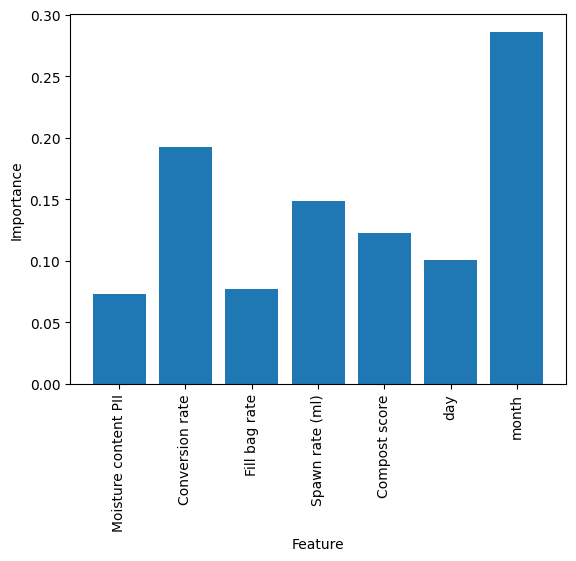

In [499]:
inputCols = X.columns[2:7].tolist() + dateCols
plt.bar(range(len(inputCols)), pipe_small.named_steps['extratreesregressor'].feature_importances_)
plt.xticks(range(len(inputCols)), inputCols, rotation='vertical')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

In [500]:
# other meteo data with more historical
import requests
response = requests.get('https://archive-api.open-meteo.com/v1/archive?latitude=-1.50&longitude=29.63&start_date=2018-01-13&end_date=2023-01-12&hourly=temperature_2m,relativehumidity_2m,dewpoint_2m,surface_pressure,rain,direct_radiation,windspeed_10m,soil_temperature_0_to_7cm,soil_moisture_0_to_7cm')

In [501]:
weatherData = pd.DataFrame(response.json()['hourly'])
weatherData['time'] = pd.to_datetime(weatherData['time'], format='%Y-%m-%d')
weatherData = weatherData.groupby(weatherData.time.dt.date).agg({'temperature_2m':'mean',
                                                   'relativehumidity_2m':'mean',
                                                   'dewpoint_2m':'mean',
                                                   'surface_pressure':'mean',
                                                   'rain':'sum',
                                                   'direct_radiation':'mean',
                                                   'windspeed_10m': 'mean',
                                                   'soil_temperature_0_to_7cm':'mean',
                                                   'soil_moisture_0_to_7cm':'mean'})

In [502]:
import warnings
warnings.filterwarnings("ignore")

arr = pd.DataFrame(columns=weatherData.columns)
inputData = allBatch.loc[:, allBatch.columns[0:9]]
for i in inputData.index:
    startDate = inputData.loc[i, 'Pre-wetting date']
    endDate = inputData.loc[i, 'Evacuation date (B)']
    arr.loc[i] = weatherData.loc[startDate:endDate, :].mean()
    
df_new = pd.concat([inputData, arr], axis=1)
df_new = pd.concat([df_new, allBatch['Kg/bag (White & Brown)']], axis=1)
df_new = column_imputer(df_new, df_new.columns)

In [551]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

df_new = _dateEncode(df_new)

y = df_new['Kg/bag (White & Brown)']
X = df_new

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

date_encoder = FunctionTransformer(_dateEncode)
scaler = StandardScaler()
dateCols = ['day', 'month']

preprocessor = ColumnTransformer(
        [
            ('dateEncode', 'passthrough', dateCols),
            ('imputer', scaler, X.columns[2:18]),
        ]
)

regressor = ExtraTreesRegressor(random_state=42)
pipe = make_pipeline(preprocessor, regressor)

pipe.fit(X_train, y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('dateEncode', 'passthrough',
                                                  ['day', 'month']),
                                                 ('imputer', StandardScaler(),
                                                  Index(['Wet straw at lay-out (T)', 'Dry straw at lay-out (T)',
       'Moisture content PII', 'Conversion rate', 'Fill bag rate',
       'Spawn rate (ml)', 'Compost score', 'temperature_2m',
       'relativehumidity_2m', 'dewpoint_2m', 'surface_pressure', 'rain',
       'direct_radiation', 'windspeed_10m', 'soil_temperature_0_to_7cm',
       'soil_moisture_0_to_7cm'],
      dtype='object'))])),
                ('extratreesregressor', ExtraTreesRegressor(random_state=42))])

In [552]:
from sklearn.metrics import mean_absolute_error
yhat = pipe.predict(X_test)
print("Mean squared error: {}".format(mean_absolute_error(yhat, y_test)))
(yhat, y_test)

Mean squared error: 2.938571428571428


(array([12.96,  5.3 , 22.08, 22.37, 23.08, 12.32, 12.75, 22.02, 28.13,
        26.07, 25.14, 24.8 , 20.16, 23.18]),
 130    14.0
 66      7.0
 107    27.0
 19     22.0
 42     29.0
 60     13.0
 12     14.0
 112    17.0
 103    24.0
 104    24.0
 44     26.0
 40     33.0
 27     16.0
 47     24.0
 Name: Kg/bag (White & Brown), dtype: float32)

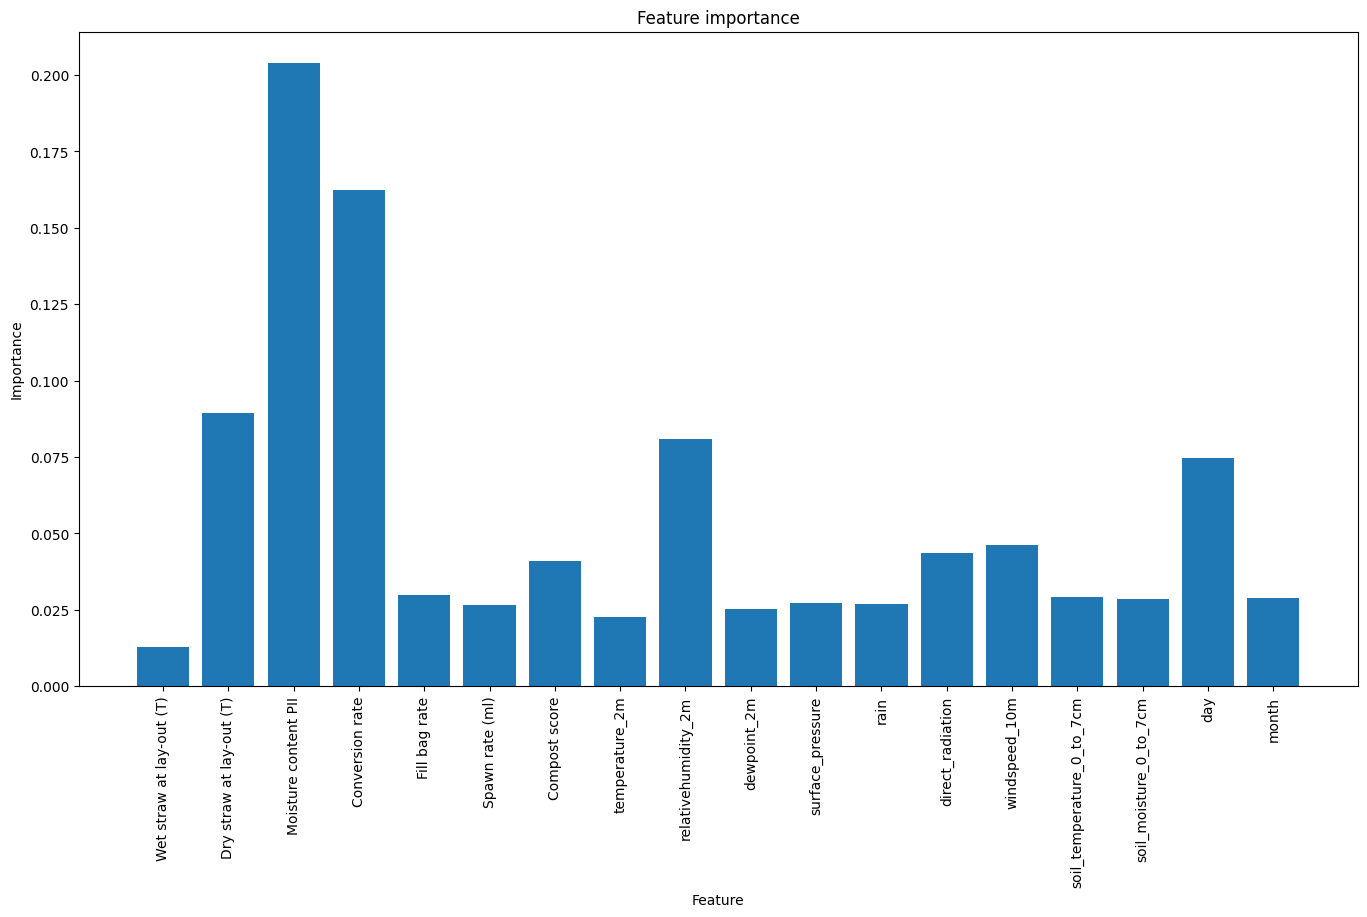

In [553]:
plt.style.use('default')
inputCols = X.columns[2:18].tolist() + dateCols
plt.figure().set_size_inches(16.5, 8.5)
plt.bar(range(len(inputCols)), pipe.named_steps['extratreesregressor'].feature_importances_)
plt.title('Feature importance')
plt.xticks(range(len(inputCols)), inputCols, rotation='vertical')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

Text(0.5, 1.0, 'Predictions vs. True Values')

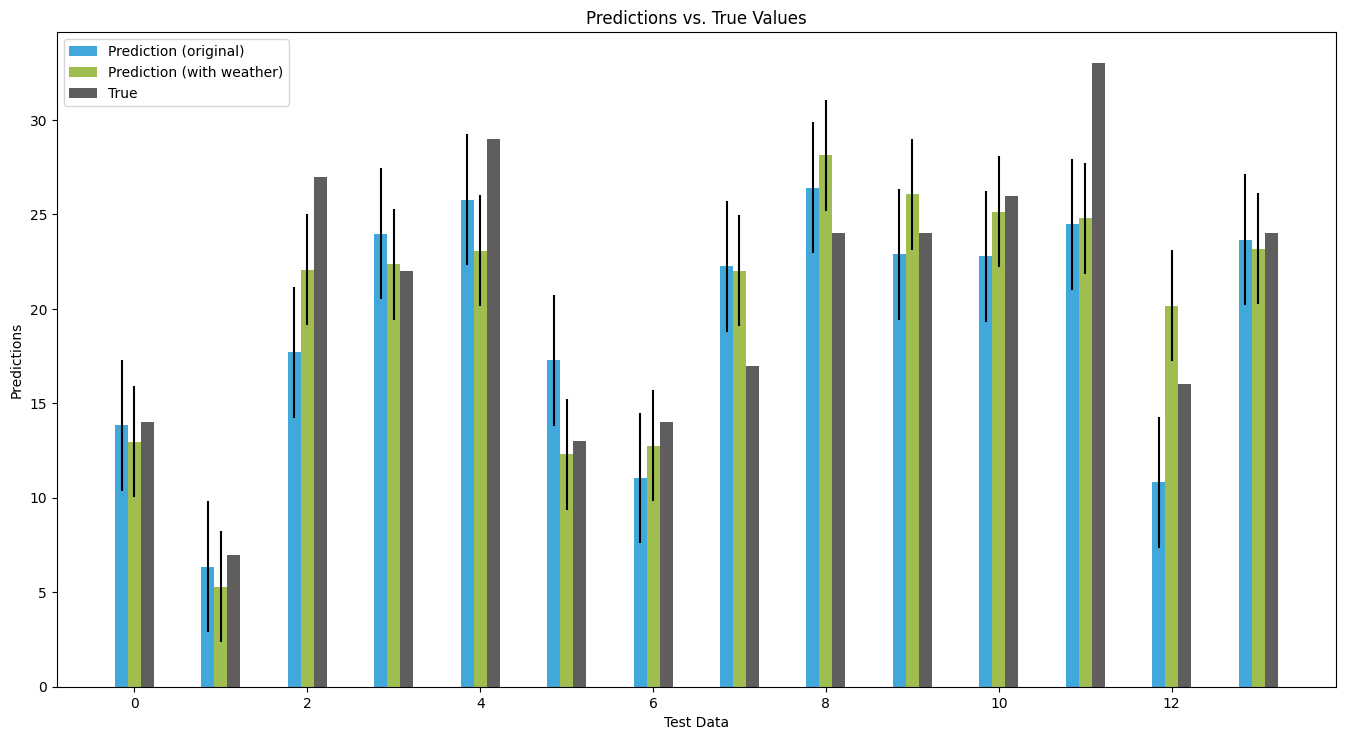

In [554]:
# Comparing models
plt.style.use('default')
plt.figure().set_size_inches(16.5, 8.5)
yhat_small = pipe_small.predict(X_test_small)
yhat = pipe.predict(X_test)
width = 0.15

# Plot the first group of bars (yhat_small) at x-coordinates 0, 1, 2, etc.
plt.bar(np.arange(len(y_test)) - width, yhat_small, width, label='Prediction (original)', yerr=mean_absolute_error(y_test, yhat_small), color='#40a8db')
plt.bar(np.arange(len(y_test)), yhat, width, label='Prediction (with weather)', yerr=mean_absolute_error(y_test, yhat), color='#a0bd50')
plt.bar(np.arange(len(y_test)) + width, y_test, width, label='True', color='#5f5d5e')
plt.legend()
plt.xlabel('Test Data')
plt.ylabel('Predictions')
plt.title('Predictions vs. True Values')

In [555]:
## ols regression of data and interpreting model further

import statsmodels.api as sm
import numpy as np
Y_ols = df_new['Kg/bag (White & Brown)']
X_ols = df_new[X.columns[2:18]]
X_ols = sm.add_constant(X_ols)
model = sm.OLS(Y_ols, X_ols)
results = model.fit()
print(results.summary())


                              OLS Regression Results                              
Dep. Variable:     Kg/bag (White & Brown)   R-squared:                       0.531
Model:                                OLS   Adj. R-squared:                  0.466
Method:                     Least Squares   F-statistic:                     8.264
Date:                    Wed, 18 Jan 2023   Prob (F-statistic):           5.96e-13
Time:                            13:09:19   Log-Likelihood:                -421.98
No. Observations:                     134   AIC:                             878.0
Df Residuals:                         117   BIC:                             927.2
Df Model:                              16                                         
Covariance Type:                nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------